In [13]:
"""Demonstrates how to load the dispersion from a separate file. In this case,
   the disperison corresponds to a silicon nitride waveguide."""

%matplotlib notebook

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import laserfun as lf
from scipy.constants import c
import scipy.interpolate

# waveguide parameters
disp_file = 'Si3N4_oxideclad_thick-750nm_widths-0.4-3.9_wav-0.40-3.00um.npz'
width = 2.3      # micron
n2 = 2.0e-19     # m^2/W
Length = 21.05   # length in mm
Alpha = 0.0      # loss (dB/cm)
# Gamma = 1000   # nonlinearity (1/(W km)) can be manually added as well,  instead of using the gamma_function()
                 # need to change the parameter for gamma while creating fiber

# pulse parameters
FWHM = 0.20           # pulse duration (ps)
pulseWL = 1560        # pulse central wavelength (nm)

power = 0.022
rep_rate = 1.3e8

EPP = power/rep_rate  # Energy per pulse (J)
#EPP = 170e-12
print(EPP)

GDD = True            # Group delay dispersion (ps^2)
TOD = False           # Third order dispersion (ps^3)
FOD = False           # Fourth order dispersion

# simulation parameters
Window = 3.0    # simulation window (ps)
Steps = 100     # simulation steps
Points = 2**12  # simulation points
rtol = 1e-4     # relative error for NLSE integrator
atol = 1e-4     # absolute error
Raman = True    # Enable Raman effect?
Steep = False   # Enable self steepening?

# load the dispersion file:
data = np.load(disp_file)
wls = data['wav']*1e3
aeff_int = scipy.interpolate.interp1d(data['widths'], data['aeff'], axis=0)
neff_int = scipy.interpolate.interp1d(data['widths'], data['neff'], axis=0)

mismatch_int = scipy.interpolate.interp1d(data['widths'],data['mismatch'], axis=0)
dispersion_int = scipy.interpolate.interp1d(data['widths'],data['dispersion'], axis=0)

aeff = aeff_int(width)
neff = neff_int(width)

mismatch = mismatch_int(width)
dispersion = dispersion_int(width)


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff)


def gamma_function(z=0):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff)
    return 2*np.pi*n2/(pulseWL*1e-9*aeff_interp(pulseWL)*1e-12)


# create the pulse:
p = lf.Pulse(pulse_type='gaussian', length=Length, fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window,power_is_avg = False, GDD=GDD, TOD=TOD, FOD=FOD, npts=Points, epp=EPP, RI=neff, wav=wls)

1.6923076923076922e-10
1.1349259319809494e-06


   1.0% - 2.126e-04 m - 0.0 seconds
   2.0% - 4.253e-04 m - 0.0 seconds
   3.0% - 6.379e-04 m - 0.0 seconds
   4.0% - 8.505e-04 m - 0.0 seconds
   5.1% - 1.063e-03 m - 0.0 seconds
   6.1% - 1.276e-03 m - 0.0 seconds
   7.1% - 1.488e-03 m - 0.0 seconds
   8.1% - 1.701e-03 m - 0.0 seconds
   9.1% - 1.914e-03 m - 0.0 seconds
  10.1% - 2.126e-03 m - 0.0 seconds
  11.1% - 2.339e-03 m - 0.0 seconds
  12.1% - 2.552e-03 m - 0.0 seconds
  13.1% - 2.764e-03 m - 0.0 seconds
  14.1% - 2.977e-03 m - 0.0 seconds
  15.2% - 3.189e-03 m - 0.0 seconds
  16.2% - 3.402e-03 m - 0.0 seconds
  17.2% - 3.615e-03 m - 0.0 seconds
  18.2% - 3.827e-03 m - 0.0 seconds
  19.2% - 4.040e-03 m - 0.0 seconds
  20.2% - 4.253e-03 m - 0.0 seconds
  21.2% - 4.465e-03 m - 0.0 seconds
  22.2% - 4.678e-03 m - 0.0 seconds
  23.2% - 4.890e-03 m - 0.0 seconds
  24.2% - 5.103e-03 m - 0.1 seconds
  25.3% - 5.316e-03 m - 0.1 seconds
  26.3% - 5.528e-03 m - 0.1 seconds
  27.3% - 5.741e-03 m - 0.1 seconds
  28.3% - 5.954e-03 m - 0.1 

<IPython.core.display.Javascript object>


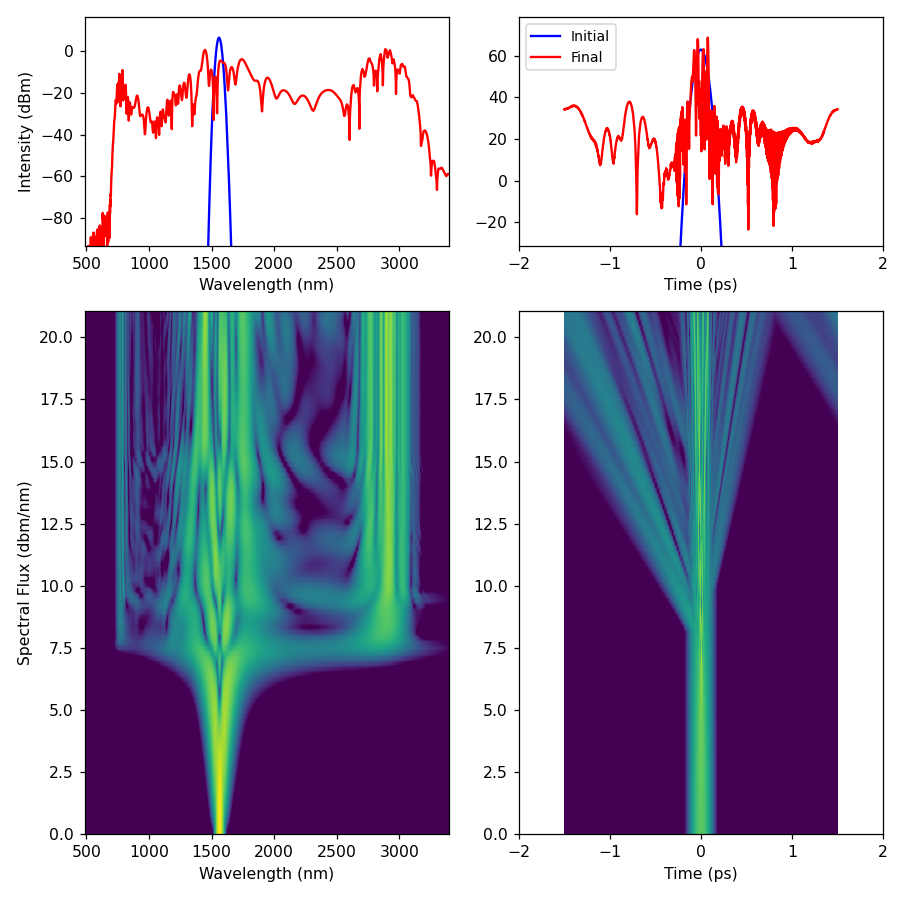

(<Figure size 800x800 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Wavelength (nm)', ylabel='Intensity (dBm)'>,
         <AxesSubplot:xlabel='Time (ps)'>],
        [<AxesSubplot:xlabel='Wavelength (nm)', ylabel='Spectral Flux (dbm/nm)'>,
         <AxesSubplot:xlabel='Time (ps)'>]], dtype=object))

In [14]:
# create the fiber
f = lf.Fiber(Length * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(), loss_dB_per_m=Alpha*100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)

results.plot(wavelength=True, show=True, tlim=(-2, 2))

In [21]:
np.abs(p.at)

array([3.55309482e-15, 1.74339709e-16, 7.66693732e-15, ...,
       7.30145349e-15, 7.79852238e-15, 1.09449863e-14])

In [25]:
max(np.abs(p.at))

35.50170764080042

In [26]:
dir(data)

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_files',
 'allow_pickle',
 'close',
 'f',
 'fid',
 'files',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'keys',
 'pickle_kwargs',
 'values',
 'zip']

In [27]:
yyy = data.files
yyy[1]

'neff'

In [28]:
type(data)

numpy.lib.npyio.NpzFile

In [5]:
list(data)

['wav', 'neff', 'aeff', 'groupidx', 'dispersion', 'mismatch', 'widths']

<IPython.core.display.Javascript object>


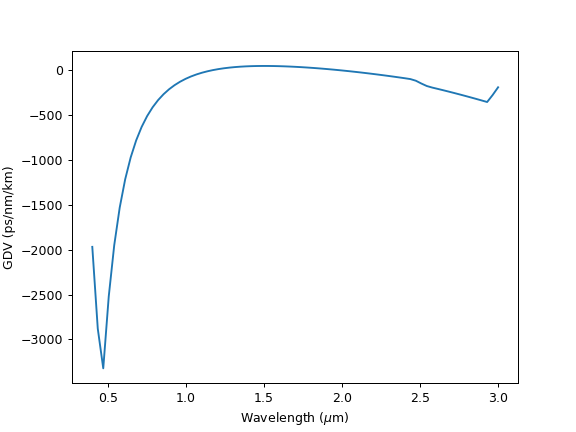

In [25]:
plt.close('all')
plt.plot(data['wav'], dispersion)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('GDV (ps/nm/km)')
plt.show()

In [3]:
data['wav']

fre = 2*np.pi*c/(data['wav']/1e6)
print(fre)

[4.70912892e+15 4.32888870e+15 4.00546598e+15 3.72701112e+15
 3.48475540e+15 3.27207080e+15 3.08385434e+15 2.91611331e+15
 2.76567889e+15 2.63000408e+15 2.50701827e+15 2.39502089e+15
 2.29260224e+15 2.19858385e+15 2.11197297e+15 2.03192735e+15
 1.95772775e+15 1.88875631e+15 1.82447927e+15 1.76443311e+15
 1.70821343e+15 1.65546575e+15 1.60587806e+15 1.55917468e+15
 1.51511104e+15 1.47346951e+15 1.43405572e+15 1.39669555e+15
 1.36123258e+15 1.32752587e+15 1.29544810e+15 1.26488399e+15
 1.23572887e+15 1.20788749e+15 1.18127302e+15 1.15580610e+15
 1.13141409e+15 1.10803033e+15 1.08559358e+15 1.06404745e+15
 1.04333994e+15 1.02342302e+15 1.00425228e+15 9.85786535e+14
 9.67987611e+14 9.50820027e+14 9.34250777e+14 9.18249117e+14
 9.02786373e+14 8.87835771e+14 8.73372281e+14 8.59372478e+14
 8.45814417e+14 8.32677515e+14 8.19942447e+14 8.07591054e+14
 7.95606256e+14 7.83971968e+14 7.72673038e+14 7.61695169e+14
 7.51024871e+14 7.40649394e+14 7.30556688e+14 7.20735346e+14
 7.11174571e+14 7.018641

In [14]:
data['widths']

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
       3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9])

In [12]:
np.shape(data['wav'])

(75,)

In [17]:
data['aeff']

array([[0.18153606, 0.18950861, 0.19811764, ...,        nan,        nan,
               nan],
       [0.2142411 , 0.22148734, 0.22918588, ...,        nan,        nan,
               nan],
       [0.24874326, 0.25571932, 0.26303897, ...,        nan,        nan,
               nan],
       ...,
       [1.38968441, 1.40750185, 1.42530545, ..., 4.02833459, 4.10639783,
        4.1867306 ],
       [1.42674815, 1.44497812, 1.46319177, ..., 4.10103992, 4.17945032,
        4.26010427],
       [1.46380089, 1.48244395, 1.50106815, ..., 4.17449221, 4.25330573,
        4.33434091]])

In [5]:
neff

array([2.08491908, 2.06606027, 2.05084285, 2.03814331, 2.02722865,
       2.01761275, 2.00895461, 2.00101599, 1.99362118, 1.98664289,
       1.97998377, 1.97357142, 1.96734901, 1.96127337, 1.95531012,
       1.94943261, 1.94361952, 1.93785401, 1.93212269, 1.92641478,
       1.92072181, 1.91503691, 1.90935477, 1.90367106, 1.89798254,
       1.89228661, 1.88658138, 1.88086545, 1.87513784, 1.86939797,
       1.86364547, 1.85788036, 1.85210268, 1.84631286, 1.84051123,
       1.83469854, 1.82887527, 1.82304241, 1.81720058, 1.81135092,
       1.80549411, 1.79963146, 1.79376365, 1.78789211, 1.78201754,
       1.77614142, 1.77026453, 1.76438831, 1.75851362, 1.75264189,
       1.74677403, 1.74091142, 1.73505505, 1.72920626, 1.72336608,
       1.7175358 , 1.71171651, 1.70590944, 1.70011574, 1.69433657,
       1.68857337, 1.6828323 , 1.677117  , 1.67142909, 1.66577039,
       1.66014244, 1.65454714, 1.64898599, 1.64346093, 1.63797342,
       1.63252543, 1.62711839, 1.62175428, 1.61643449, 1.61116

In [6]:
aeff

array([0.87124686, 0.88337437, 0.89553462, 0.90777211, 0.92013296,
       0.93265016, 0.94534699, 0.9582431 , 0.97135692, 0.98470482,
       0.99830273, 1.01216536, 1.02630735, 1.04074267, 1.05548535,
       1.07054919, 1.08594808, 1.10169597, 1.11780696, 1.13429538,
       1.15117578, 1.1684631 , 1.18617254, 1.20431978, 1.22292086,
       1.24199236, 1.26155133, 1.28161539, 1.30220276, 1.32333225,
       1.34502339, 1.36729634, 1.39017215, 1.41367244, 1.43781996,
       1.46263797, 1.48815111, 1.51438445, 1.54136474, 1.56911905,
       1.59767646, 1.62706625, 1.65732007, 1.68846966, 1.72054946,
       1.75359402, 1.78764072, 1.82272731, 1.8588944 , 1.89618327,
       1.93463805, 1.97430393, 2.01522899, 2.05746268, 2.10105742,
       2.1460674 , 2.19254983, 2.24056413, 2.29017281, 2.34144107,
       2.39443975, 2.44929443, 2.50610789, 2.56496823, 2.62596718,
       2.68920264, 2.75477612, 2.82279658, 2.8933766 , 2.96663767,
       3.04270485, 3.12171386, 3.20380391, 3.28912689, 3.37783

<IPython.core.display.Javascript object>


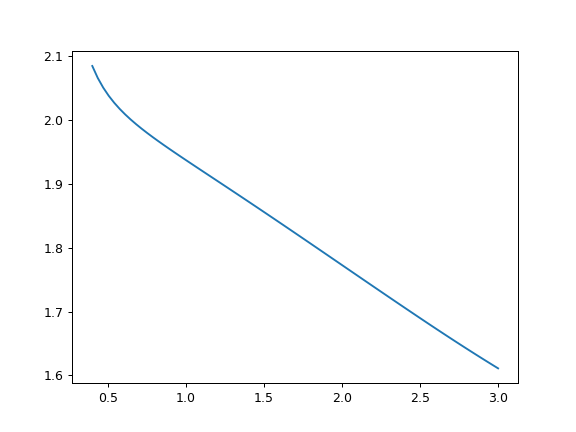

In [24]:
plt.plot(data['wav'],neff)